# Introduction and Background

## Research Question
Are there specific months for movie release dates that generate more revenue in the box office? Is there a correlation between movie budgets and their success in the box office?

## Background
This is a question of interest because the film industry may be able to find some different strategies to maximize their revenue, such as the best time to release their new movies or determine how much their budget will correlate to potential revenue. With so many movies always coming out, we wondered if there was a correlation between box office success and release dates in conjunction with how big a movie’s budgets is. In some of our background research we found that the number of user votes on IMDB for a movie corresponds with how well-known the film is, and that critics’ reviews don’t have that much of an influence on the success of a movie. 

We always hear about big budget movies because they’re the ones that usually have the ability to advertise the film to the point where everyone sees it. But sometimes movies with relatively small budgets rise to the top of the the box offices. Content has something to do with it, but we want to see how much of an impact the time at which you release a movie has on the success of the film. There have been some blog posts about which genre generally gets released for each month, and there was some indication that the winter months would be when the best movies (Oscar nominated ones) come out. 

Our question is important because it presents a visualization for the correlation between box office success and release dates in conjuction with movie budgets. We want to know if there is a strong correlation and if there is a pattern to movie release dates. It is unclear if there are popular months for movie releases or box office success. 

References (include links):
- Movie Budget and Financial Performance Records (https://www.the-numbers.com/movie/budgets/) 
-- Tables that show top 20 movies that compare the movie's budget and revenue (greatest lost and earnings).
- Analysis of factor affecting the success of the movie (http://rstudio-pubs-static.s3.amazonaws.com/233939_bbeb292c0c20440f97d31b616662c06f.html)
-- Analysis between different website user voting data and the success of the movie in the box office in conjuction with the movie's budget. 
- Movie Release Calendar Strategy (https://riotstudios.com/blog/movie-release-calendar-strategy/) 
-- Months associated with genre/movie style released.

## Hypothesis
We predict that if a movie is released during July or August, then it will generate more revenue in the box office. We also predict that if a movie has a big budget, then it will generate more revenue in the box office. 

# Data Description

This is a list of ~5000 movies from The Movie Database website. This dataset contains rows of movies with columns that dictate details of the movie. For example, the list contains keyword, revenue, budget, production company, imdb id, language, runtime, release date, and ratings concerning each movie.

- Dataset Name: TMDb 5000 Movie Dataset
- Link to the dataset: https://www.kaggle.com/tmdb/tmdb-movie-metadata/data
- Number of observations: 4803

This is a list of ~45000 movies from The Movie Database. This list contains budget, genre, original language, popularity, revenue, imdb id, adulterated, production company, homepage, collection, poster, overview, video, tagline, title, vote count, id, runtime, release date, and vote average (0-10) for each movie. 

- Dataset Name: Movies Metadata
- Link to the dataset: https://www.kaggle.com/rounakbanik/the-movies-dataset/data
- Number of observations: 45466

We may be merging the datasets and compare if there are any duplicates, if so, we will compare the ‘revenue’, ‘budget’, and ‘release date’ and remove the duplicates. If there are any conflicting comparisons, we will manually change the data to the correct values. 

## Data Cleaning/Pre-processing


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

!pip install easymoney
from easymoney.money import EasyPeasy

C:\Users\amilkcarton\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
# Import datafile tmdb_5000_movies.csv to df1

df1 = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
# Import datafile movies_metadata.csv to df2
df2 = pd.read_csv('movies_metadata.csv', low_memory=False)

In [4]:
# Drop unrelated columns
df1.drop(['homepage', 'keywords', 'overview', 'runtime', 'tagline'], axis=1, inplace=True)
df2.drop(['adult', 'belongs_to_collection', 'homepage', 'imdb_id', 'overview', 'poster_path', 'runtime', 'video', 'tagline'], axis=1, inplace=True)

In [5]:
# Change str to int and drop all unnemerical elements
pd.to_numeric(df1['revenue'], errors='coerce')
pd.to_numeric(df1['budget'], errors='coerce')
pd.to_numeric(df2['revenue'], errors='coerce')
pd.to_numeric(df2['budget'], errors='coerce') 

df1.dropna(subset = ["revenue","budget"],inplace=True)
df2.dropna(subset = ["revenue","budget"],inplace=True)
df2.budget = df2.budget.astype(np.int64)

In [6]:
# Drop unrepresentable/abnormal value for revenue and budget 
df1 = df1[df1.revenue >= 1000]
df2 = df2[df2.revenue >= 1000]
df1 = df1[df1.budget >= 1000]
df2 = df2[df2.budget >= 1000]

In [7]:
# Concat two dataset into one called df
df = pd.concat([df1, df2], ignore_index=True)

In [8]:
# Drop repeated infomation.
df.drop_duplicates('id', inplace=True)

In [9]:
# Split the release date to year month and date 
df['year'] = pd.DatetimeIndex(df['release_date']).year
df['month'] = pd.DatetimeIndex(df['release_date']).month
df['date'] = pd.DatetimeIndex(df['release_date']).day

In [10]:
# Remove the movies that may be too old
df = df[df.year >= 1990]
#df['gender'].value_counts()

In [11]:
# Adjust inflation rate 
ep = EasyPeasy()

In [12]:
# Adjust the inflation of budget, make a new column called adjusted_budget
adjusted_budget = []
for index, row in df.iterrows():
    adjusted_budget.append(ep.normalize(amount=row['budget'], region="US", from_year=row['year'], to_year='latest',base_currency="USD", pretty_print=False))
df['adjusted_budget'] = adjusted_budget

C:\Users\amilkcarton\Anaconda3\lib\site-packages\easymoney\money.py:213: UserWarning: 
Inflation (CPI) data for 2017 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 2016.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))


In [13]:
# Adjust the inflation of revenue, make a new column called adjusted_revenue
adjusted_revenue = []
for index, row in df.iterrows():
    adjusted_revenue.append(ep.normalize(amount=row['revenue'], region="US", from_year=row['year'], to_year='latest',base_currency="USD", pretty_print=False))
df['adjusted_revenue'] = adjusted_revenue

C:\Users\amilkcarton\Anaconda3\lib\site-packages\easymoney\money.py:213: UserWarning: 
Inflation (CPI) data for 2017 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 2016.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))


In [14]:
# Add column return_rate and profit
df['return_rate'] = df['adjusted_revenue']/df['adjusted_budget']
df['profit'] = df['adjusted_revenue']- df['adjusted_budget']

#df['return_rate'].value_counts()
#extrem = df['return_rate']>40
#df[extrem]

In [15]:
# In this step, we are going to deal with outlier values by removing all rows in which the data for the steps column exceeds +/- 3 standard deviations above or below the mean.
std3 = 3 * df['return_rate'].std()
std_max = df['return_rate'].mean() + std3
std_min = df['return_rate'].mean() - std3

In [16]:
# Now use these values to remove any rows with steps data above or below these thresholds
df = df[df['return_rate'] > std_min]
df = df[df['return_rate'] < std_max]

In [17]:
# Use the method below to extract the main genres. 
def extract_main_genre(genres):
    s = genres
    # Find the first : after id
    start = s.find(':') + 1
    s = s[start:]
    start = s.find(':') + 3
    end = s.find('}') - 1
    return s[start:end]
df['main_genre'] = df["genres"].apply(extract_main_genre)

In [18]:
# Use the method below to extract the main production company
def extract_main_production(companies):
    return companies[companies.find(':') + 3: companies.find(",") - 1]
df['main_production_company'] = df['production_companies'].apply(extract_main_production)

In [20]:
# Check if any rows have empty genre
empty_genre = sum(df.main_genre == '')
empty_production = sum(df.main_production_company == '')

print ("There are ", empty_genre, " rows that do not contain a genre.")
print ("There are ", empty_production, " rows that do not contain a production company.")

There are  9  rows that do not contain a genre.
There are  184  rows that do not contain a production company.
7103


In [23]:
# Function to check empty column values
def empty_string(string):
    output = None
    if (string == ''):
        output = np.nan
    else:
        output = string
    return output

In [24]:
# Applying the transformation and dropping invalid rows
df["main_production_company"] = df["main_production_company"].apply(empty_string)
df.dropna(subset=['main_production_company'], inplace=True)

6919


In [25]:
# Applying the transformation and dropping invalid rows
df["main_genre"] = df["main_genre"].apply(empty_string)
df.dropna(subset=['main_genre'], inplace=True)

6918


In [26]:
# Check what the df looks like as of now
df.head()
df

,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,...,vote_count,year,month,date,adjusted_budget,adjusted_revenue,return_rate,profit,main_genre,main_production_company
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,en,Avatar,150.438,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2.787965e+09,...,11800.0,2009,12,10,2.651370e+08,3.118957e+09,11.763566,2.853820e+09,Action,Ingenious Film Partners
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,en,Pirates of the Caribbean: At World's End,139.083,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,9.610000e+08,...,4500.0,2007,5,19,3.472620e+08,1.112396e+09,3.203333,7.651340e+08,Adventure,Walt Disney Pictures
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,en,Spectre,107.377,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,8.806746e+08,...,4466.0,2015,10,26,2.480909e+08,8.917851e+08,3.594590,6.436942e+08,Action,Columbia Pictures
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,en,The Dark Knight Rises,112.313,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1.084939e+09,...,9106.0,2012,7,16,2.613388e+08,1.134147e+09,4.339756,8.728078e+08,Action,Legendary Pictures
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,en,John Carter,43.927,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,2.841391e+08,...,2124.0,2012,3,7,2.717923e+08,2.970263e+08,1.092843,2.523393e+07,Action,Walt Disney Pictures
5,258000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",559,en,Spider-Man 3,115.7,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-01,8.908716e+08,...,3576.0,2007,5,1,2.986454e+08,1.031220e+09,3.452991,7.325743e+08,Fantasy,Columbia Pictures
6,260000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",38757,en,Tangled,48.682,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2010-11-24,5.917949e+08,...,3330.0,2010,11,24,2.861742e+08,6.513710e+08,2.276134,3.651968e+08,Animation,Walt Disney Pictures
7,280000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",99861,en,Avengers: Age of Ultron,134.279,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-04-22,1.405404e+09,...,6767.0,2015,4,22,2.835324e+08,1.423134e+09,5.019299,1.139602e+09,Action,Marvel Studios
8,250000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",767,en,Harry Potter and the Half-Blood Prince,98.8856,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2009-07-07,9.339592e+08,...,5293.0,2009,7,7,2.796804e+08,1.044840e+09,3.735837,7.651599e+08,Adventure,Warner Bros.
9,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",209112,en,Batman v Superman: Dawn of Justice,155.79,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""A...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016-03-23,8.732602e+08,...,7004.0,2016,3,23,2.500000e+08,8.732602e+08,3.493041,6.232602e+08,Action,DC Comics


# Data Visualization
First, we need to do some exploratory data visualization, to get a feel for the data. 


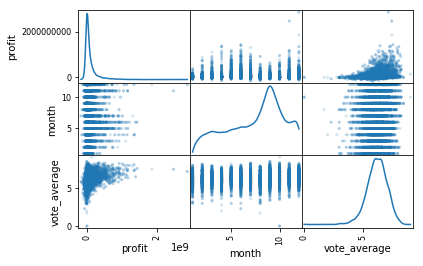

In [27]:
# Plot the data, using scatter_matrix, from Pandas. Assign it to a variable called 'fig'.
fig = pd.plotting.scatter_matrix(df[['profit','month','vote_average']], alpha=0.2, diagonal='kde')

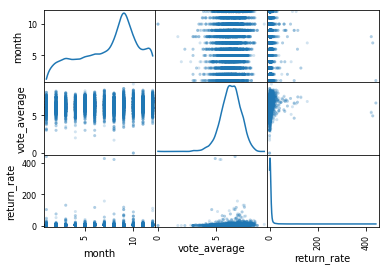

In [28]:
fig = pd.plotting.scatter_matrix(df[['month','vote_average','return_rate']], alpha=0.2, diagonal='kde')

We can see that most of the movies' return rates are close to each other and under 100, but there are some movies with extremely high return rate.

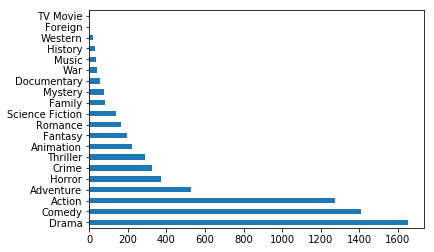

In [61]:
# Plot a bar chart showing the number of movies in each genre. 
df.main_genre.value_counts().plot.barh()
f1 = plt.gcf()

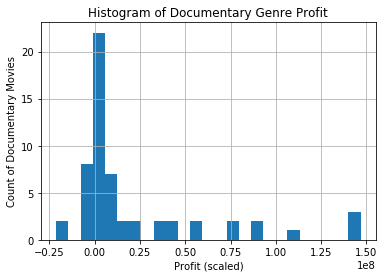

In [54]:
df[df["main_genre"] == 'Documentary'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Documentary Movies')
plt.title('Histogram of Documentary Genre Profit')
f_Documentary = plt.gcf()

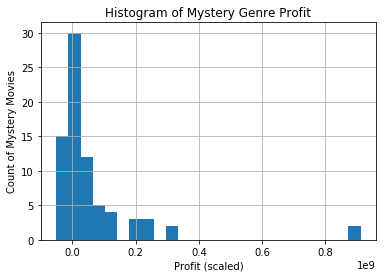

In [55]:
df[df["main_genre"] == 'Mystery'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Mystery Movies')
plt.title('Histogram of Mystery Genre Profit')
f_Mystery = plt.gcf()

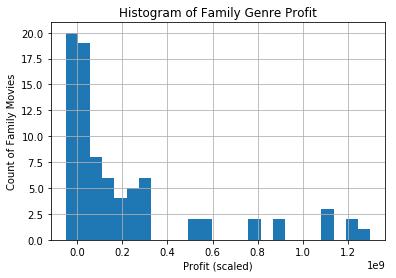

In [56]:
df[df["main_genre"] == 'Family'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Family Movies')
plt.title('Histogram of Family Genre Profit')
f_Family = plt.gcf()

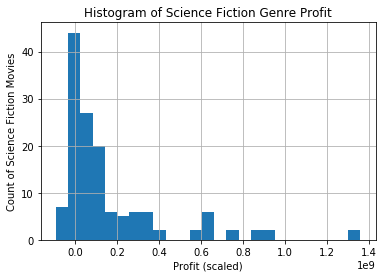

In [62]:
df[df["main_genre"] == 'Science Fiction'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Science Fiction Movies')
plt.title('Histogram of Science Fiction Genre Profit')
f_Science_Fiction = plt.gcf()

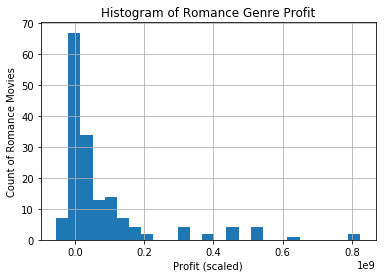

In [63]:
df[df["main_genre"] == 'Romance'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Romance Movies')
plt.title('Histogram of Romance Genre Profit')
f_Romance = plt.gcf()

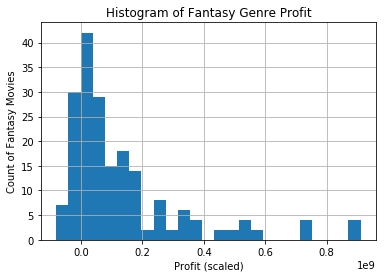

In [64]:
df[df["main_genre"] == 'Fantasy'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Fantasy Movies')
plt.title('Histogram of Fantasy Genre Profit')
f_Fantasy = plt.gcf()

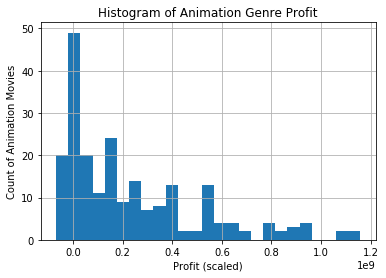

In [38]:
df[df["main_genre"] == 'Animation'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Animation Movies')
plt.title('Histogram of Animation Genre Profit')
f_Animation = plt.gcf()

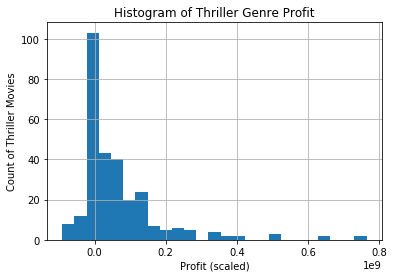

In [39]:
df[df["main_genre"] == 'Thriller'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Thriller Movies')
plt.title('Histogram of Thriller Genre Profit')
f_Animation = plt.gcf()

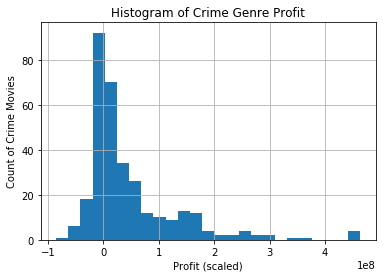

In [41]:
df[df["main_genre"] == 'Crime'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Crime Movies')
plt.title('Histogram of Crime Genre Profit')
f_Crime = plt.gcf()

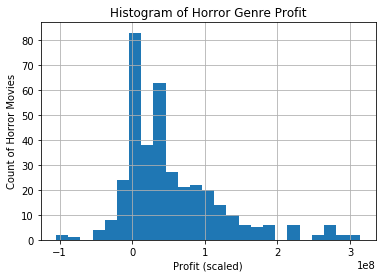

In [43]:
df[df["main_genre"] == 'Horror'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Horror Movies')
plt.title('Histogram of Horror Genre Profit')
f_Horror = plt.gcf()

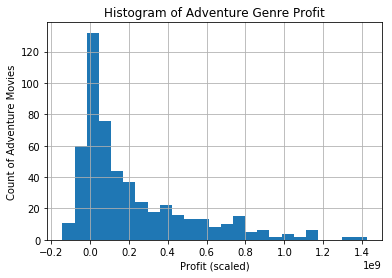

In [45]:
df[df["main_genre"] == 'Adventure'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Adventure Movies')
plt.title('Histogram of Adventure Genre Profit')
f_Adventure = plt.gcf()

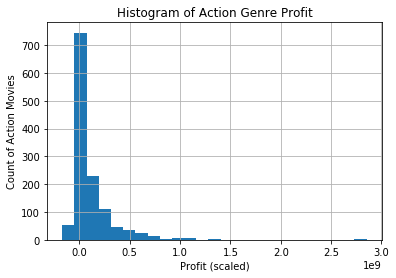

In [47]:
df[df["main_genre"] == 'Action'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Action Movies')
plt.title('Histogram of Action Genre Profit')
f_Action = plt.gcf()

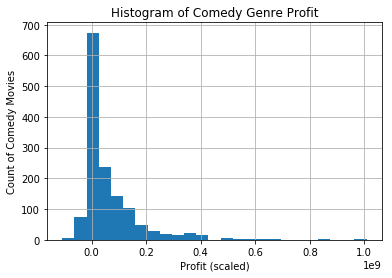

In [50]:
df[df["main_genre"] == 'Comedy'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Comedy Movies')
plt.title('Histogram of Comedy Genre Profit')
f_Comedy = plt.gcf()

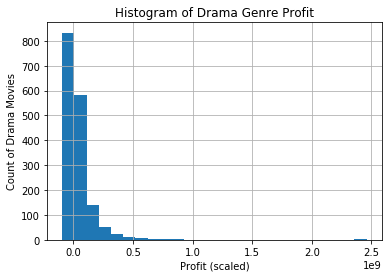

In [52]:
df[df["main_genre"] == 'Drama'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Drama Movies')
plt.title('Histogram of Drama Genre Profit')
f_Drama = plt.gcf()

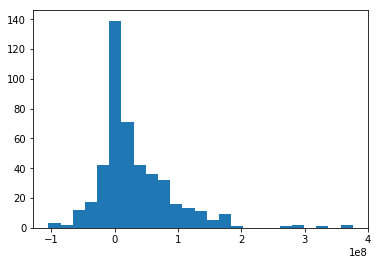

In [65]:
toPlot_Jan = df[df["month"]==1]['profit']
n, bins, patches = plt.hist(toPlot_Jan, 25)
f1 = plt.gcf()

In [ ]:
toPlot_Feb = df[df["month"]==2]['profit']
n, bins, patches = plt.hist(toPlot_Feb, 25)
f2 = plt.gcf()

In [ ]:
toPlot_Mar= df[df["month"]==3]['profit']
n, bins, patches = plt.hist(toPlot_Mar, 25)
f3 = plt.gcf()

In [ ]:
toPlot_Apr= df[df["month"]==4]['profit']
n, bins, patches = plt.hist(toPlot_Apr, 25)
f4 = plt.gcf()

In [ ]:
toPlot_May= df[df["month"]==5]['profit']
n, bins, patches = plt.hist(toPlot_May, 25)
f5 = plt.gcf()

In [ ]:
toPlot_Jun = df[df["month"]==6]['profit']
n, bins, patches = plt.hist(toPlot_Jun, 25)
f6 = plt.gcf()

In [ ]:
toPlot_Jul = df[df["month"]==7]['profit']
n, bins, patches = plt.hist(toPlot_Jul, 25)
f7 = plt.gcf()

In [ ]:
toPlot_Aug = df[df["month"]==8]['profit']
n, bins, patches = plt.hist(toPlot_Aug, 25)
f8 = plt.gcf()

In [ ]:
toPlot_Sep = df[df["month"]==9]['profit']
n, bins, patches = plt.hist(toPlot_Sep, 25)
f9 = plt.gcf()

In [ ]:
toPlot_Oct = df[df["month"]==10]['profit']
n, bins, patches = plt.hist(toPlot_Oct, 25)
f10 = plt.gcf()

In [ ]:
toPlot_Nov = df[df["month"]==11]['profit']
n, bins, patches = plt.hist(toPlot_Nov, 25)
f11 = plt.gcf()

In [ ]:
toPlot_Dec = df[df["month"]==12]['profit']
n, bins, patches = plt.hist(toPlot_Dec, 25)
f12 = plt.gcf()

# Data Analysis and Results¶


In [ ]:
# Use the 'describe' pandas method to check a descriptive summary of the data
desc = df.describe()

In [ ]:
# Test the distribution for 
pro_jan = df[df['month'] == 1]['profit'].values
pro_feb = df[df['month'] == 2]['profit'].values
pro_mar = df[df['month'] == 3]['profit'].values
pro_apr = df[df['month'] == 4]['profit'].values
pro_may = df[df['month'] == 5]['profit'].values
pro_jun = df[df['month'] == 6]['profit'].values
pro_jul = df[df['month'] == 7]['profit'].values
pro_aug = df[df['month'] == 8]['profit'].values
pro_sep = df[df['month'] == 9]['profit'].values
pro_oct = df[df['month'] == 10]['profit'].values
pro_nov = df[df['month'] == 11]['profit'].values
pro_dec = df[df['month'] == 12]['profit'].values



#should we test the distribution?    
#st_jan,p_jan = stats.normaltest(pro_jan)

#alpha = 0.000001
#if p_jan > alpha: 
#    is_n_jan = True
#else:
#    is_n_jan = False
   


In [ ]:
#xs = np.arange(pro_jan.min(), pro_jan.max(), 0.1)
#fit = stats.norm.pdf(xs, np.mean(pro_jan), np.std(pro_jan))
#plt.plot(xs, fit, label='Normal Dist.', lw=4)
#plt.hist(pro_jan, normed=True, label='Actual Data');
#plt.title('January - profit')
#plt.legend();

In [ ]:
avg_pro_jan = pro_jan.mean()
avg_pro_feb = pro_feb.mean()
avg_pro_mar = pro_mar.mean()
avg_pro_apr = pro_apr.mean()
avg_pro_may = pro_may.mean()
avg_pro_jun = pro_jun.mean()
avg_pro_jul = pro_jul.mean()
avg_pro_aug = pro_aug.mean()
avg_pro_sep = pro_sep.mean()
avg_pro_oct = pro_oct.mean()
avg_pro_nov = pro_nov.mean()
avg_pro_dec = pro_dec.mean()
print('Average profit of movie in January is \t {:2.2f} dollar'.format(avg_pro_jan))
print('Average profit of movie in Febuaray is \t {:2.2f} dollar'.format(avg_pro_feb))
print('Average profit of movie in March is \t {:2.2f} dollar'.format(avg_pro_mar))
print('Average profit of movie in April is \t {:2.2f} dollar'.format(avg_pro_apr))
print('Average profit of movie in May is \t {:2.2f} dollar'.format(avg_pro_may))
print('Average profit of movie in June is \t {:2.2f} dollar'.format(avg_pro_jun))
print('Average profit of movie in July is \t {:2.2f} dollar'.format(avg_pro_jul))
print('Average profit of movie in August is \t {:2.2f} dollar'.format(avg_pro_aug))
print('Average profit of movie in September is \t {:2.2f} dollar'.format(avg_pro_sep))
print('Average profit of movie in October is \t {:2.2f} dollar'.format(avg_pro_oct))
print('Average profit of movie in November is \t {:2.2f} dollar'.format(avg_pro_nov))
print('Average profit of movie in December is \t {:2.2f} dollar'.format(avg_pro_dec))

In [ ]:
list = [avg_pro_jan,avg_pro_feb,avg_pro_mar,avg_pro_apr,avg_pro_may,avg_pro_jun,avg_pro_jul,avg_pro_aug,avg_pro_sep,
        avg_pro_oct,avg_pro_nov,avg_pro_dec]
list.sort(key=int)
print(list)

In June, May,November , december and July, the profit is a lot higher than the movies in the rest of the months.

Now, let's find the average profit of movies in different genres

In [ ]:
pro_Drama = df[df['main_genre'] == "Drama"]['profit'].values
pro_Comedy = df[df['main_genre'] == "Comedy"]['profit'].values
pro_Action = df[df['main_genre'] == "Action"]['profit'].values
pro_Adventure = df[df['main_genre'] == "Adventure"]['profit'].values
pro_Crime = df[df['main_genre'] == "Crime"]['profit'].values
pro_Horror = df[df['main_genre'] == "Horror"]['profit'].values
pro_Animation = df[df['main_genre'] == "Animation"]['profit'].values
pro_Fantasy = df[df['main_genre'] == "Fantasy"]['profit'].values
pro_Thriller = df[df['main_genre'] == "Thriller"]['profit'].values
pro_Romance = df[df['main_genre'] == "Romance"]['profit'].values
pro_ScienceFiction = df[df['main_genre'] == "Science Fiction"]['profit'].values


In [ ]:
avg_pro_Drama = pro_Drama.mean()
avg_pro_Comedy = pro_Comedy.mean()
avg_pro_Action = pro_Action.mean()
avg_pro_Adventure = pro_Adventure.mean()
avg_pro_Crime = pro_Crime.mean()
avg_pro_Animation = pro_Animation.mean()
avg_pro_Horror = pro_Horror.mean()
avg_pro_Thriller = pro_Thriller.mean()
avg_pro_Fantasy = pro_Fantasy.mean()
avg_pro_Romance = pro_Romance.mean()
avg_pro_ScienceFiction = pro_ScienceFiction.mean()

In [ ]:
print('Average profit of Drama movie is \t {:2.2f} dollar'.format(avg_pro_Drama))
print('Average profit of Comedy movie is \t {:2.2f} dollar'.format(avg_pro_Comedy))
print('Average profit of Action movie is \t {:2.2f} dollar'.format(avg_pro_Action))
print('Average profit of Adventure movie is \t {:2.2f} dollar'.format(avg_pro_Adventure))
print('Average profit of Horror movie is \t {:2.2f} dollar'.format(avg_pro_Horror))
print('Average profit of Crime movie is \t {:2.2f} dollar'.format(avg_pro_Crime))
print('Average profit of Animation movie is \t {:2.2f} dollar'.format(avg_pro_Animation))
print('Average profit of Thriller movie is \t {:2.2f} dollar'.format(avg_pro_Thriller))
print('Average profit of Fantasy movie is \t {:2.2f} dollar'.format(avg_pro_Fantasy))
print('Average profit of Romance movie is \t {:2.2f} dollar'.format(avg_pro_Romance))
print('Average profit of Science Fiction movie is \t {:2.2f} dollar'.format(avg_pro_ScienceFiction))


# Privacy/Ethics Considerations


# Conclusions and Discussions¶
